In [1]:
import theano
import theano.tensor as T
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using cuDNN version 5105 on context None
Mapped name None to device cuda: GeForce GT 740M (0000:01:00.0)


In [4]:
from utils import get_network_str,load_weights
from symbols import make_net
import theano.tensor as T

data = T.tensor4(name='data')
net = make_net(data)
print get_network_str(net,incomings=True,outgoings=True)


In -->      Layer    --> Out     Description                                        
-------     -----    -------     -----------                                        
[]          0        [1]         data(None, 3, None, None)                          
[0]         1        [2]         unet3_in_conv(3)(None, 6, None, None)              
[1]         2        [3]         unet3_in_bn(None, 6, None, None)                   
[2]         3        [4, 22]     unet3_in_relu(None, 6, None, None)                 
[3]         4        [5]         unet3_pool(None, 6, None, None)                    
[4]         5        [6]         unet2_in_conv(3)(None, 12, None, None)             
[5]         6        [7]         unet2_in_bn(None, 12, None, None)                  
[6]         7        [8, 15]     unet2_in_relu(None, 12, None, None)                
[7]         8        [9]         unet2_pool(None, 12, None, None)                   
[8]         9        [10]        unet1_in_conv(3)(None, 24, None

In [7]:
load_weights(net,'models/gmm099_loss-234.46')
X = lasagne.layers.get_output(net)
#X  =T.transpose(X,(0,2,3,1))
features_fn = theano.function([data],X)

In [11]:
from gmm_op import get_gmm,calc_log_prob_gmm,calc_log_prob_gmm_componetwise,GMM
from theano_utils import histogram_loss,split,accuracy
from lasagne.regularization import regularize_network_params,l2

net_output = T.fmatrix('features')
general_dist = net_output[:,:1]
X = net_output[:,1:]
X = X/T.sqrt(T.square(X).sum(1)+np.float32(1e-8))[:,None]
means,covars,weights = get_gmm(X,4,24,True)
p = calc_log_prob_gmm_componetwise(X,means,covars,weights)
p = T.nnet.softmax(T.concatenate([p,general_dist],axis=1))
rate = weights/(T.mean(covars,1)+np.float32(1e-8))
rate_param = theano.shared(np.float32(10.),name='rate_param',allow_downcast=True)
soft_sign = T.concatenate([T.tanh(rate-rate_param),-T.ones((1,))])
prediction = T.max((1.+T.sgn(p-T.max(p,1)[:,None]+np.float32(1e-10)))*T.sgn(soft_sign)[None,:],1)-1.

predict_pixelwise = theano.function([net_output],[prediction])

In [18]:
from numba import jit
from sklearn import mixture

@jit
def classify(features,gm_num=2,rate=0,ws=(2,2)):
    gmm = mixture.GaussianMixture(covariance_type='diag',n_components=gm_num, max_iter=100)
    mask = np.zeros((features.shape[0],features.shape[1],features.shape[2]),dtype=np.uint8)
    for i in range(features.shape[1]//ws[0]):
        for j in range(features.shape[2]//ws[1]):
            vec_to_classify = features[:,i*ws[1]:(i+1)*ws[1],j*ws[0]:(j+1)*ws[0],:].reshape((-1,features.shape[-1]))
            score = predict_pixelwise(vec_to_classify)[0]
            score = score.reshape((len(mask),ws[1],ws[0]))
            mask[:,i*ws[1]:(i+1)*ws[1],j*ws[0]:(j+1)*ws[0]][(score >= rate)] = 255
    return mask
    

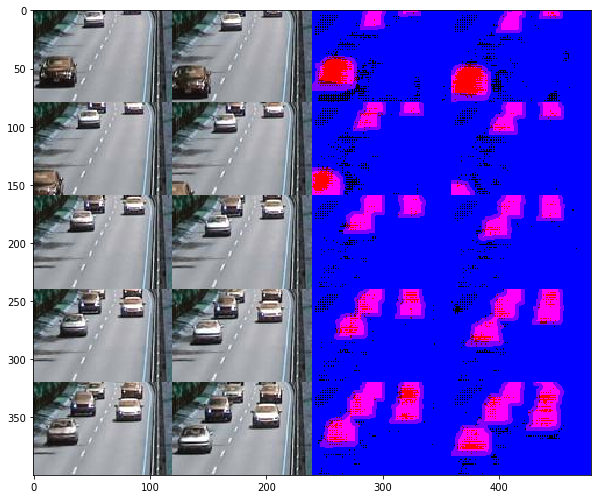

In [20]:
import os
folder = '/media/data/Programming/motion_segmentation/gmm_segmentation/dataset/baseline/highway'

def resize(im,mask,size):
    im = cv2.resize(im,size)
    mask = cv2.resize(mask,size)
    mask[mask < 30] = 0
    mask[(mask >=30)&(mask <230)] = 255//2
    mask[(mask >=230)] = 255
    return im,mask
    
def iterate_video(folder,min_rate = 0.01):
    for name in [i[2:-4] for i in os.listdir(folder+'/input') if (i[-4:] == '.jpg')]:
        mask = cv2.imread(folder+'/groundtruth/gt'+name+'.png',0)
        if((mask[(mask>30)&(mask < 230)].size > mask.size//2) | (mask[mask > 230].size < min_rate*mask.size)):
            continue
        im = cv2.imread(folder+'/input/in'+name+'.jpg')
        yield im,mask
    
def iterate_bathced(folder,num_frames,size):
    imgs  = np.zeros((num_frames,size[1],size[0],3),dtype=np.uint8)
    masks = np.zeros((num_frames,size[1],size[0]),dtype=np.uint8)
    for i,(im,mask) in enumerate(iterate_video(folder)):
        im,mask = resize(im,mask,size)
        imgs[i % num_frames] = im
        masks[i % num_frames] = mask
        if((i+1)%num_frames == 0):
            yield imgs,masks

def draw(_imgs,_mask,_out,cols=10,rows=10):
    res =_imgs[:cols*rows,...].copy()
    _,h,w,c = res.shape
    mask = np.zeros_like(res)
    res = np.transpose(res.reshape((rows,cols,h,w,c)),(0,2,1,3,4)).reshape((rows*h,cols*w,c))
    mask[...,0] = _mask[:cols*rows,:,:]
    mask[...,2] = _out[:cols*rows,:,:]
    mask = np.transpose(mask.reshape((rows,cols,h,w,c)),(0,2,1,3,4)).reshape((rows*h,cols*w,c))
    plt.figure(figsize=(10,10))
    plt.imshow(np.concatenate((res,mask),axis=1))
    plt.show()

for imgs,masks in iterate_bathced(folder,100,(320,240)):
    imgs =imgs[:,:80,170:170+120]
    masks = masks[:,:80,170:170+120]
    features = features_fn(np.transpose(imgs,(0,3,1,2)).astype(np.float32))
    features = np.transpose(features,(0,2,3,1))
    out = classify(features)
    draw(imgs[::10],masks[::10],out[::10],2,5)
    break

In [27]:
rate_param.set_value(110.48)

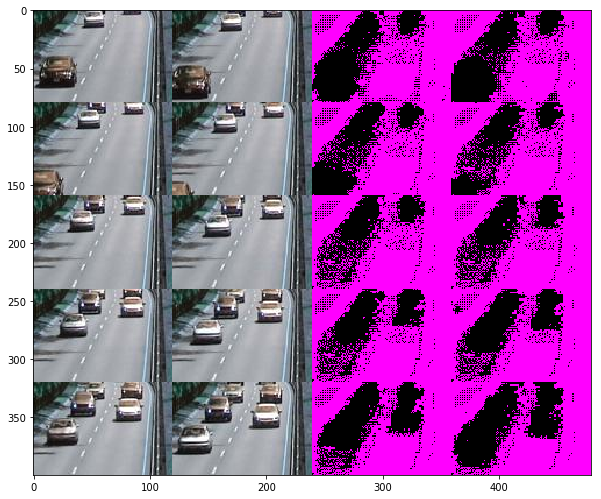

In [28]:

out = classify(features,rate=0.0)
draw(imgs[::10],out[::10],out[::10],2,5)

In [10]:

f = features

In [35]:
imgs.shape

(100, 80, 120, 3)

In [16]:

#features = imgs

In [88]:
print features.shape,masks.shape

(100, 80, 120, 24) (100, 80, 120)


[ 135.71054167   12.87196214  202.46539479]


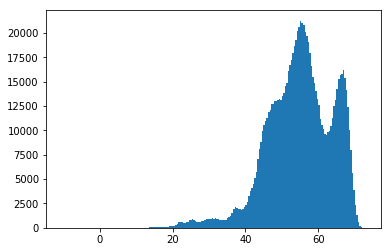

In [138]:

gmm = mixture.GaussianMixture(covariance_type='diag',n_components=3, max_iter=1000)
vec_to_classify = features.reshape((-1,features.shape[-1]))
gmm.fit(vec_to_classify[masks.flatten()<100])
rates = gmm.weights_/np.linalg.norm(gmm.covariances_,axis=1)
print rates
score,amax = prob_fn(vec_to_classify,gmm.means_,gmm.covariances_,gmm.weights_)
plt.hist(score,bins=200)
plt.draw()          

In [139]:
amax = amax.reshape(features[:,...].shape[:-1])

In [140]:
m = np.zeros_like(amax)

In [141]:
rates = gmm.weights_/np.linalg.norm(gmm.covariances_,axis=1)
print rates

[ 135.71054167   12.87196214  202.46539479]


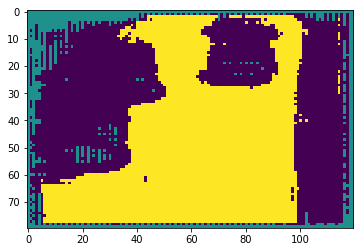

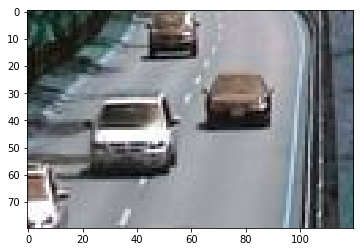

In [142]:
plt.imshow(amax[10])
plt.show()
plt.imshow(imgs[:,...][10])
plt.show()

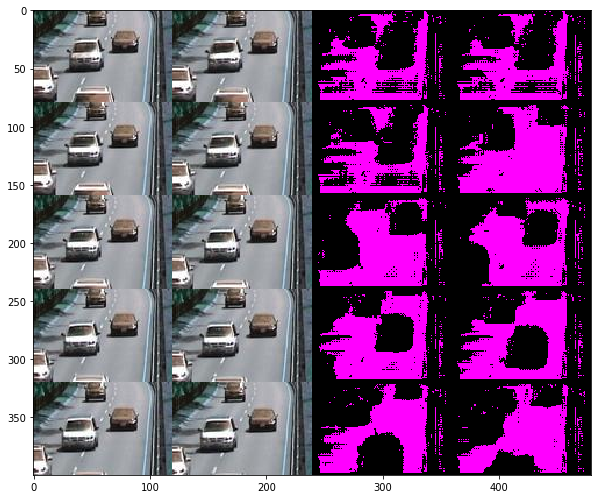

In [146]:
out = np.zeros_like(masks)
out[score.reshape(out.shape) > 60] = 255
draw(imgs[:10],out,out,cols=2,rows=5)

In [ ]:
class MOGSegmentator:
    def __init__(self,n_comp):
        self.n_comp = n_comp
        self.gmm = mixture.GaussianMixture(covariance_type='diag',n_components=n_comp, max_iter=100)
    def segment(self,features):
        

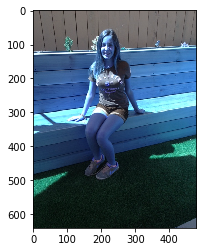

In [70]:
img =cv2.imread('img_1742.jpg')
plt.imshow(img)
features = features_fn(np.transpose(img,(2,0,1))[np.newaxis].astype(np.float32))

In [71]:
s = slice(200,350),slice(340,400),slice(None,None)

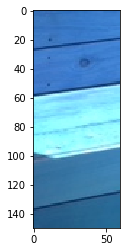

In [72]:
plt.imshow(img[s])

In [73]:
features= np.transpose(features[0],(1,2,0))
features = img.astype(np.float32)

In [74]:
gmm = mixture.GaussianMixture(covariance_type='diag',n_components=5, max_iter=100)
train = features[s]
print train.shape
gmm.fit(train.reshape((-1,features.shape[-1])))
score,amax = prob_fn(features.reshape((-1,features.shape[-1])),gmm.means_,gmm.covariances_,gmm.weights_)
score = score.reshape(features.shape[:-1])

(150, 60, 3)


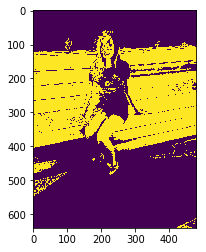

In [83]:
mask = np.zeros_like(score)
mask[score > -20] = 255
plt.imshow(mask)